# Post-classification Analysis
**Mudgee NSW - Change Detection Jan 2005 to Jan 2024**

Author: Michael Dear, May 2024

## Usage
This notebook should be run after completing the [DEA Data Preparation](dea_data_prep.ipynb) and the [Classification Data Preparation](class_data_prep.ipynb) notebooks.

## Setup

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

# Custom functions
from custom_functions import *

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [7]:
from global_params import *

# Class variable of interest
class_var = 'Kmeans_Class'
# Class labels
cl_labels = ['Bare; Dry; Urban', 'Forest Edge', 'Forest', 'Crops; Green Grass']

## Step 1: Load data

In [3]:
ds=xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = [ds.period.values[0], ds.period.values[1]]
periods

['Feb 2005', 'Feb 2024']

## Step 2: Plots
<a id='plots'></a>
The following plots compare the current year to the 5-year mean and the previous year. High-resolution versions are saved in the `ouput` directory for closer visual assessment. The plots are a quicker alternative than loading the exported geoTIFF's into a GIS.

### Plotting Parameters and Functions

In [8]:
# Bands for standard RGB plots
rgb_vars = ['nbart_red', 'nbart_green', 'nbart_blue']

# Main plot parameters
rgb_params = {
    'robust':True,
}

ndvi_params = {
    'robust':True,
    'cmap':'RdYlGn',
    'add_colorbar':False,
    'vmin':0,
    'vmax':1
}

class_params = {
    # 'levels':[0,1,2,3,4,5],
    'levels':np.append(
                np.unique(ds.NDVI_Class.values), 
                [ds.NDVI_Class.values.max()+1]
                ),
    'cmap':'RdYlGn',
    'add_colorbar':False,
}

### True-colour (RGB)
*Note*: For `imshow`, the rgb values need to be converted to decimal by dividing by $2^{12}$ (Sentinel 2 is 12 bit), then scaling to 255 before converting to `np.uint8`. See https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

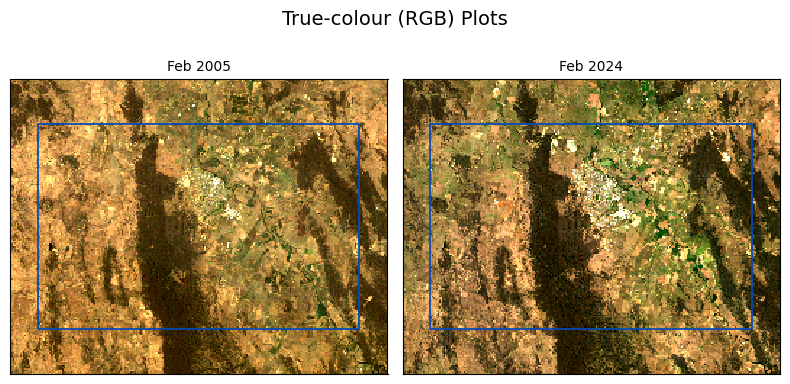

In [10]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

for i, period in enumerate(ds.period.values):
    (
     ds[rgb_vars]
     .sel(period=period)
     .to_array()
     .plot
     .imshow(ax=axes[i], **rgb_params)
    )
    
    axes[i].set_title(period, fontsize=10)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    poly.boundary.plot(ax=ax, linewidth=1.25, color='#0249ba')
    
fig.suptitle('True-colour (RGB) Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'RGB_plots_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

### NDVI

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (3).

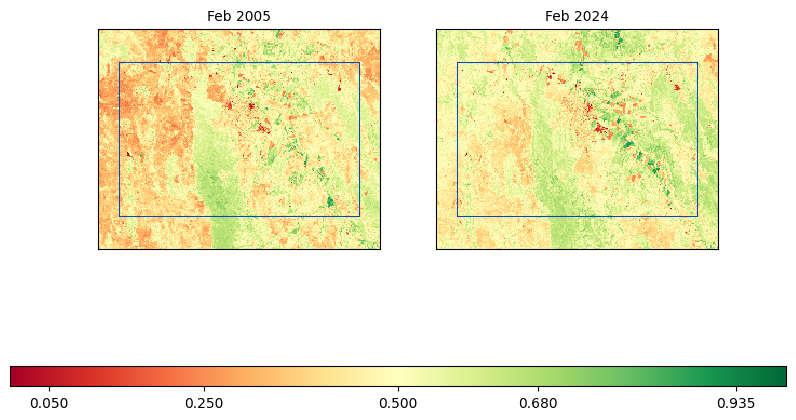

In [11]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

for i, period in enumerate(ds.period.values):
    colour = (ds
     .NDVI
     .sel(period=period)
     .plot(ax=axes[i], **ndvi_params)
    )

    axes[i].set_title(period, fontsize=10)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks([0.05, 0.25, 0.5, 0.68, 0.935])
cb.set_ticklabels(cl_labels[:-1])
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

fig.suptitle('NDVI Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'NDVI_plots_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

In [14]:
np.unique(ds.NDVI_Class.values)

array([0, 1, 2, 3, 4], dtype=int16)

### Classification

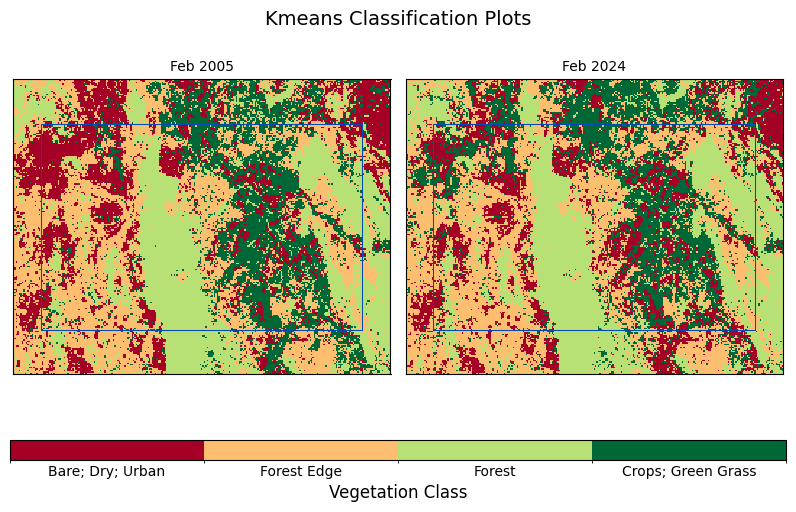

In [12]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

for i, period in enumerate(ds.period.values):
    colour = (ds[class_var]
     # .NDVI_Class
     .sel(period=period)
     .plot(ax=axes[i], **class_params)
    )

    axes[i].set_title(period, fontsize=10)

for i, ax in enumerate(axes.flat):
    remove_labels_ticks(ax)
    poly.boundary.plot(ax=ax, linewidth=0.75, color='#0249ba')


# Add colorbar - horizontal at bottom
cax = fig.add_axes([0.015, 0, 0.97, 0.04]) # Horizontal at bottom
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'horizontal', 
                         )

cb.set_ticks(class_params['levels'][:-1]+0.5)
cb.set_ticklabels(cl_labels)
cb.ax.tick_params(size=0)
cb.set_label('Vegetation Class', fontsize=12)

fig.suptitle(class_var[:-6]+' Classification Plots', y=0.9, fontsize=14)
fig.tight_layout()

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+class_var+'_plots_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

## Step 7: Class Change Statistics
This section examines the change in the number of pixels in each class between the two periods. The change is reported as the absolute and proportional pixel change. All statistics are based on the study site internal area, excluding the surrounding area. 

*Note*: Boundary pixels have been counted as part of the study site internal area.

### Study area statistics

In [13]:
bbox_area = int(ds.sizes['x']*ds.sizes['y']*spatial_res**2/area_unit_val)
site_area_px = int(mask.count().values*spatial_res**2/area_unit_val)
site_area_poly = int(poly.area/area_unit_val)

print('Bounding box area =', bbox_area, area_unit)
print('Study site area (pixels) =', site_area_px , area_unit)
print('Study site area (polygon) =', site_area_poly, area_unit)
print('Study site area as % of bounding box area =', int((site_area_px/bbox_area)*100), '%')

Bounding box area = 53244 ha
Study site area (pixels) = 31666 ha
Study site area (polygon) = 31620 ha
Study site area as % of bounding box area = 59 %


### Extract data for the classification variable of interest

In [14]:
# Extract the masked classification data arrays for each period.
class_das = [ds[class_var].sel(period=period).where(mask.notnull()) for period in periods]
class_das

[<xarray.DataArray 'Kmeans_Class' (y: 204, x: 261)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * y        (y) float64 -3.659e+06 -3.659e+06 ... -3.679e+06 -3.679e+06
   * x        (x) float64 1.619e+06 1.619e+06 1.619e+06 ... 1.645e+06 1.645e+06
     period   <U8 'Feb 2005',
 <xarray.DataArray 'Kmeans_Class' (y: 204, x: 261)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * y        (y) float64 -3.659e+06 -3.659e+06 ... -3.679e+06 -3.679e+06
   * x        (x) float64 1.619e+06 1.619e

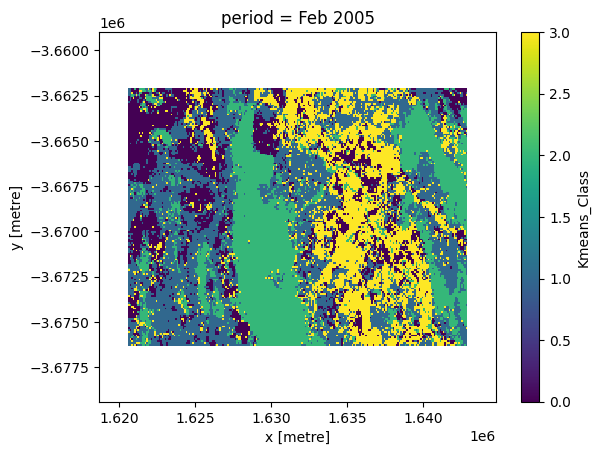

In [15]:
# Test plot
class_das[0].plot()

### Annual class statistics

In [23]:
data = np.array([[int(da.where(da == cl).count().values) for cl in np.arange(len(cl_labels))] for da in class_das])*spatial_res**2/area_unit_val


In [24]:
df_annual_classes = pd.DataFrame(
    data = data,
    index=periods,
    columns = cl_labels
)

# Add a row total column
df_annual_classes['Total'] = df_annual_classes.sum(axis=1)

df_annual_classes

,Bare; Dry; Urban,Forest Edge,Forest,Crops; Green Grass,Total
Feb 2005,5865.0,10747.0,8123.0,6931.0,31666.0
Feb 2024,6029.0,10460.0,8379.0,6798.0,31666.0


In [25]:
df_annual_classes_prop = df_annual_classes.div(df_annual_classes.Total, axis=0).round(3)*100
df_annual_classes_prop

,Bare; Dry; Urban,Forest Edge,Forest,Crops; Green Grass,Total
Feb 2005,18.5,33.9,25.7,21.9,100.0
Feb 2024,19.0,33.0,26.5,21.5,100.0


### Annual class difference statistics

In [26]:
data = np.array([[int(da.where(da == cl).count().values) for da in class_das] for cl in np.arange(len(cl_labels))])*spatial_res**2/area_unit_val


In [27]:
df_annual_class_diff = pd.DataFrame(
    data = data,
    columns = periods,
    index = cl_labels
)

# Add a difference column
df_annual_class_diff[periods[1]+'-'+periods[0]] = df_annual_class_diff[periods[1]] - df_annual_class_diff[periods[0]]

# Add a percentage change column
df_annual_class_diff['Change_%'] = (df_annual_class_diff[periods[1]+'-'+periods[0]]
                                    .div(df_annual_class_diff[periods[0]], axis=0)
                                    .round(3)
                                    *100
                                   )

df_annual_class_diff

,Feb 2005,Feb 2024,Feb 2024-Feb 2005,Change_%
Bare; Dry; Urban,5865.0,6029.0,164.0,2.8
Forest Edge,10747.0,10460.0,-287.0,-2.7
Forest,8123.0,8379.0,256.0,3.2
Crops; Green Grass,6931.0,6798.0,-133.0,-1.9


### Class change matrix
This section investigates the change between classes between the two periods.

In [28]:
def change_mat(arrs, cl_labels):
    '''
    Create a change matrix from a list of exactly two data arrays.
    The data array values represent classes for the same classification method.
    Rows will represent the first array and columns will represent the second array in the returned data frame.
    
    arrs: Two data arrays of the same size and shape.
    cl_labels: A list of all the class labels used in the classification. 
    There can be a maximum of 256 classes. 
    The label list needs to match the ascending order of the class numbers in the array values.
    '''
    
    # Create the pairs of corresponding class values
    tuples = (list(zip(arrs[0].values.reshape(-1), arrs[1].values.reshape(-1))))
    
    # Get the unique pairs and their frequencies
    # https://stackoverflow.com/a/51793947/8299958
    unique, counts = np.unique(tuples, axis=0, return_counts=True)
    
   
    # Strip pairs containing any nan
    sel = np.array(~np.isnan(unique).any(axis=1))
    counts = counts[sel]
    unique = unique[sel]
  
    
    # Create an empty matrix with dimensions equal to the number of classes
    num_cl = len(cl_labels)
    mat = np.zeros((num_cl,num_cl), dtype=np.int32)
    
    # Fill the matrix
    for n in np.arange(len(unique)):
        # row = (unique[n][0]-1 ).astype(np.uint8) # row index
        # col = (unique[n][1]-1 ).astype(np.uint8) # column index
        row = (unique[n][0]).astype(np.uint8) # row index
        col = (unique[n][1]).astype(np.uint8) # column index        
        mat[row, col] = counts[n] # update the matrix

    # Create the multiindex
    r_index = pd.MultiIndex.from_product([[periods[0]], cl_labels], names=['Period','Class'])
    c_index = pd.MultiIndex.from_product([[periods[1]], cl_labels], names=['Period','Class'])

    
    # Create the data frame
    df = pd.DataFrame(
            data = mat*spatial_res**2/area_unit_val, # convert to area unit
            index = r_index,
            columns = c_index        
            )
    
    # Proportional data frame as a percentage of row total
    # https://stackoverflow.com/a/50820765/8299958
    df_prop = df.div(df.sum(axis=1), axis=0).round(3)*100
    
    return (df, df_prop)

In [29]:
change_mat_prev_curr = change_mat(class_das, cl_labels)

In [30]:
change_mat_prev_curr[0]

Period                              Feb 2024                      \
Class                       Bare; Dry; Urban Forest Edge  Forest   
Period   Class                                                     
Feb 2005 Bare; Dry; Urban             3701.0       284.0     4.0   
         Forest Edge                   132.0      9502.0   449.0   
         Forest                         10.0       181.0  7878.0   
         Crops; Green Grass           2186.0       493.0    48.0   

Period                                          
Class                       Crops; Green Grass  
Period   Class                                  
Feb 2005 Bare; Dry; Urban               1876.0  
         Forest Edge                     664.0  
         Forest                           54.0  
         Crops; Green Grass             4204.0

In [31]:
change_mat_prev_curr[1]

Period                              Feb 2024                     \
Class                       Bare; Dry; Urban Forest Edge Forest   
Period   Class                                                    
Feb 2005 Bare; Dry; Urban               63.1         4.8    0.1   
         Forest Edge                     1.2        88.4    4.2   
         Forest                          0.1         2.2   97.0   
         Crops; Green Grass             31.5         7.1    0.7   

Period                                          
Class                       Crops; Green Grass  
Period   Class                                  
Feb 2005 Bare; Dry; Urban                 32.0  
         Forest Edge                       6.2  
         Forest                            0.7  
         Crops; Green Grass               60.7

### Class Change Map

In [33]:
# Pandas data frame of change class labels
df_ch_cl = pd.DataFrame(
               data = [(x,y) for x in np.arange(len(cl_labels)) for y in np.arange(len(cl_labels))],
               columns = ['cl0','cl1']
)

# Create the change labels
df_ch_cl['ch_cl_label'] = [cl_labels[df_ch_cl.cl0[i]-1] +' --> '+cl_labels[df_ch_cl.cl1[i]-1] for i in df_ch_cl.index]
df_ch_cl.loc[[df_ch_cl.cl0[i] == df_ch_cl.cl1[i] for i in df_ch_cl.index], 'ch_cl_label'] = 'No Change'

# Create the change class numbers column
df_ch_cl['ch_cl_num'] = 0

# All 'No Change' should be class 0
# Locate the changed classes
changed = np.array([df_ch_cl.cl0[i] != df_ch_cl.cl1[i] for i in df_ch_cl.index])
# Create a list of numbers for the changed classes
cl_nums = np.arange(changed.sum())+1

# Iterate to add cl_nums to changed classes; leave 'No Change' = 0
i = 0
j = 0
while i < len(df_ch_cl.index):
    if changed[i]:
        df_ch_cl.loc[i,'ch_cl_num'] = cl_nums[j]
        j += 1
    i += 1

# Add an Missing class
# nan = -999 requied since np.nan == np.nan --> False
df_nan = pd.DataFrame({'cl0':-999, 'cl1':-999, 'ch_cl_label':'Missing', 'ch_cl_num':df_ch_cl.ch_cl_num.max()+1},
                     index=[0])
df_ch_cl = pd.concat([df_ch_cl, df_nan], axis=0, ignore_index=True)


df_ch_cl

,cl0,cl1,ch_cl_label,ch_cl_num
0,0,0,No Change,0
1,0,1,Crops; Green Grass --> Bare; Dry; Urban,1
2,0,2,Crops; Green Grass --> Forest Edge,2
3,0,3,Crops; Green Grass --> Forest,3
4,1,0,Bare; Dry; Urban --> Crops; Green Grass,4
5,1,1,No Change,0
6,1,2,Bare; Dry; Urban --> Forest Edge,5
7,1,3,Bare; Dry; Urban --> Forest,6
8,2,0,Forest Edge --> Crops; Green Grass,7
9,2,1,Forest Edge --> Bare; Dry; Urban,8


#### Data frame of tuples

In [34]:
df_tuples = pd.DataFrame(
    {'cl0':class_das[0].values.reshape(-1), 'cl1':class_das[1].values.reshape(-1)}
)

# Convert nan to np.nan to match df_ch_cl.ch_cl_pairs
df_tuples = df_tuples.fillna(-999)

df_tuples

,cl0,cl1
0,-999.0,-999.0
1,-999.0,-999.0
2,-999.0,-999.0
3,-999.0,-999.0
4,-999.0,-999.0
...,...,...
53239,-999.0,-999.0
53240,-999.0,-999.0
53241,-999.0,-999.0
53242,-999.0,-999.0


In [35]:
df_tuples.shape

(53244, 2)

#### Merge df_tuples with df_ch_cl using ch_cl_pairs

In [36]:
# Must include how='left' to maintain original order
df_ch_map = df_tuples.merge(df_ch_cl, how='left')
df_ch_map.head()

,cl0,cl1,ch_cl_label,ch_cl_num
0,-999.0,-999.0,Missing,13
1,-999.0,-999.0,Missing,13
2,-999.0,-999.0,Missing,13
3,-999.0,-999.0,Missing,13
4,-999.0,-999.0,Missing,13


In [37]:
df_ch_map.shape

(53244, 4)

#### Create the change map data array

In [38]:
da_change_map = xr.DataArray(
    data = np.array(df_ch_map.ch_cl_num).reshape(ds[class_var].shape[1:]),
    coords = {'y':ds[class_var].coords['y'], 'x':ds[class_var].coords['x']}
)

# Set the crs
da_change_map = da_change_map.rio.write_crs(crs)

da_change_map

<xarray.DataArray (y: 204, x: 261)>
array([[13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       ...,
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13],
       [13, 13, 13, ..., 13, 13, 13]], dtype=int64)
Coordinates:
  * y            (y) float64 -3.659e+06 -3.659e+06 ... -3.679e+06 -3.679e+06
  * x            (x) float64 1.619e+06 1.619e+06 ... 1.645e+06 1.645e+06
    spatial_ref  int32 0

#### Change Map Plot

In [39]:
# These are the change classes of interest based on the class change matrix
ch_map_nums = np.array([1,8,11])
da_change_map_filt = da_change_map.where(da_change_map.isin(ch_map_nums))

In [40]:
# Get the unique ch_cl_nums
ch_cl_num_unq = np.unique(da_change_map.values)
# Filter for the change class numbers of interest
ch_cl_num_unq = ch_cl_num_unq[np.isin(ch_cl_num_unq,ch_map_nums)]
# Add an extra number at the end to avoid losing the last class
ch_cl_num_unq = np.append(ch_cl_num_unq, ch_cl_num_unq.max()+1)
print(ch_cl_num_unq)

# Set axis tick locations halfway between ch_cl_num
ax_tick_loc = [(ch_cl_num_unq[i]+ch_cl_num_unq[i+1])/2 for i in np.arange(len(ch_cl_num_unq)-1)]
print(ax_tick_loc)

# Exclude the highest ch_cl_num because it is the Missing class
ax_tick_labels = np.array(df_ch_cl.ch_cl_label[df_ch_cl.ch_cl_num.isin(ch_cl_num_unq[:-1])].unique())
print(ax_tick_labels)

[ 1  8 11 12]
[4.5, 9.5, 11.5]
['Crops; Green Grass --> Bare; Dry; Urban'
 'Forest Edge --> Bare; Dry; Urban' 'Forest --> Bare; Dry; Urban']


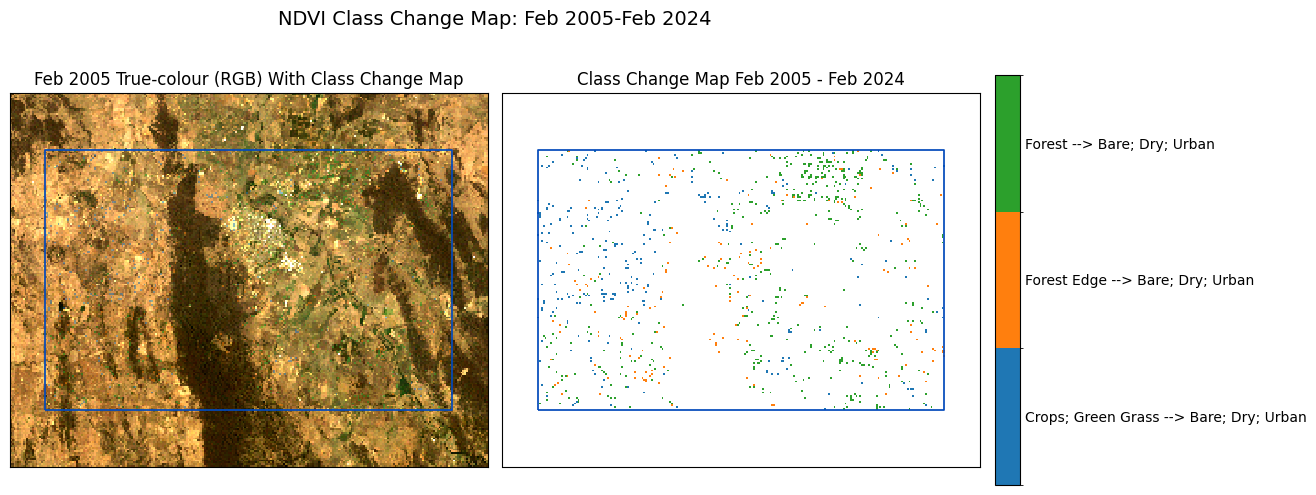

In [41]:
# alpha value for RGB plot overlay
alpha = 0.5

# Class colours
colors=['#EEEEEE', 
        'gold', 
        'sandybrown',
        'limegreen', 
        'mediumorchid', 
        'forestgreen', 
        'orangered', 
        'teal']

# Alternative to manually naming colours
import matplotlib as mpl
cmap = mpl.colormaps['tab10']  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, axes = plt.subplots(1,2,figsize=(10,5))

(ds[rgb_vars]
     .isel(period=0)
     .to_array()
     .plot
     .imshow(ax=axes[0], **rgb_params)
)

da_change_map_filt.plot(ax=axes[0], 
                            add_colorbar=False,
                            levels=ch_cl_num_unq,  
                            # cmap='tab10' # Try this first, then set some custom colours
                            # Custom colours; second element of tuple is alpha
                            colors=[(color, alpha) for color in colors]
                           )

axes[0].set_title(periods[0]+' True-colour (RGB) With Class Change Map')


colour = da_change_map_filt.plot(ax=axes[1], 
                   add_colorbar=False,
                   levels=ch_cl_num_unq,  
                   # cmap='tab10'
                 # Custom colours; second element of tuple is alpha
                 colors= colors
                 )

axes[1].set_title('Class Change Map '+periods[0]+' - '+periods[1])


for ax in fig.axes:
    remove_labels_ticks(ax)
    poly.boundary.plot(ax=ax, linewidth=1.25, color='#0249ba')


# Add colorbar - Vertical at side
cax = fig.add_axes([1, 0.09, 0.025, 0.82])
cb = fig.colorbar(
                          colour, 
                          cax=cax, 
                          orientation = 'vertical', 
                         )

cb.set_ticks(ax_tick_loc)
cb.set_ticklabels(ax_tick_labels)
cb.ax.tick_params(size=0)
# cb.set_label('Change Class', fontsize=11)


fig.tight_layout()
fig.suptitle('NDVI Class Change Map: '+periods[0]+'-'+periods[1], y=1.04, fontsize=14)

# bbox_inches = "tight" is required to stop labels at edges being cut off
# https://stackoverflow.com/questions/35992492/savefig-cuts-off-title
fig.savefig(img_dir+'NDVI_change_map_'+periods[0]+'-'+periods[1]+'.png', dpi=600, bbox_inches = "tight");

plt.show()
plt.close('all')

## Export Data

In [42]:
da_change_map.rio.to_raster(geotiff_dir+study_area_abbrev+'_'+class_var+'_change_map.tiff')